Train samples: 23017
Validation samples: 2877
Test samples: 2878
Example record:
{'instruction': 'extract aspect term-opinion term pairs from the sentence', 'input': "Heck , I like all Mac computers , but they 're all WAY too pricey for the kind of economy the U.S. is going through .", 'output': 'there are no aspect term-opinion term pairs in the sentence.', 'text': "extract aspect term-opinion term pairs from the sentence <NAME> , I like all <NAME> computers , but they 're all WAY too pricey for the kind of economy the U.S. is going through .", 'label': 1, 'input_ids': [0, 16435, 15664, 6659, 1385, 12, 1517, 31210, 1385, 15029, 31, 5, 3645, 28696, 48307, 15698, 2156, 38, 101, 70, 28696, 48307, 15698, 7796, 2156, 53, 51, 128, 241, 70, 26727, 350, 26428, 13, 5, 761, 9, 866, 5, 121, 4, 104, 4, 16, 164, 149, 479, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

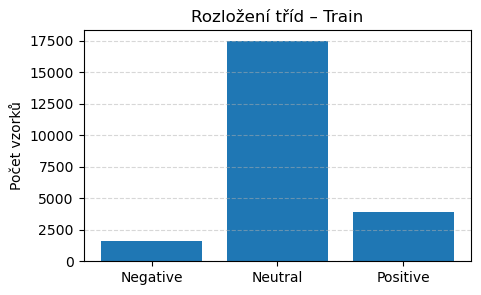


Validation - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2180 (75.77%)
  Positive:   491 (17.07%)


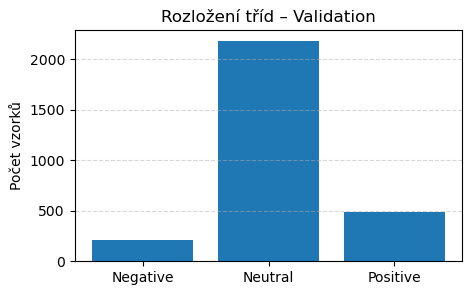


Test - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2181 (75.78%)
  Positive:   491 (17.06%)


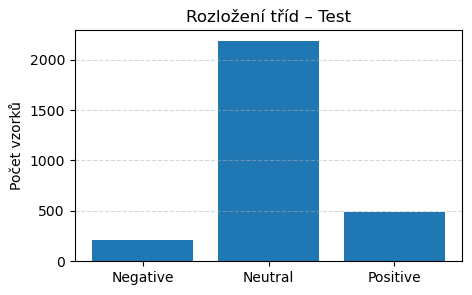

Počet vzorků v třídách: Counter({1: 17443, 2: 3927, 0: 1647})
Vypočítané váhy tříd:
  Negative: 4.6584
  Neutral : 0.4399
  Positive: 1.9537


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_796/2933411540.py:193: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Step,Training Loss
100,0.867100
200,0.526000
300,0.505900
400,0.466800
500,0.413700
600,0.418800
700,0.374300
800,0.426100
900,0.402200
1000,0.389500


Výsledky na testovacích datech:
eval_loss   : 0.4776
eval_accuracy: 0.9256
eval_precision: 0.9275
eval_recall : 0.9256
eval_f1     : 0.9264
eval_runtime: 5.2550
eval_samples_per_second: 547.6700
eval_steps_per_second: 34.2530
epoch       : 3.0000


In [1]:
from datasets import load_dataset
import re
from transformers import RobertaTokenizer

import pandas as pd
import matplotlib.pyplot as plt

# Načtení datasetu 
ds = load_dataset("yuncongli/chat-sentiment-analysis", split="train")

#Funkce pro maskování citlivých údajů 
def mask_sensitive(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "<EMAIL>", text)
    text = re.sub(r"http\S+|www\.\S+", "<URL>", text)
    text = re.sub(r"\+?\d[\d\-\s]{7,}\d", "<PHONE>", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "<USER>", text)
    text = re.sub(r"\b\d{4,}\b", "<NUMBER>", text)
    # jednoduchá heuristika pro jména (velké písmeno uprostřed věty)
    text = re.sub(r"(?<![.!?]\s)(?<!^)(\b[A-Z][a-z]+)", "<NAME>", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

#  Funkce pro extrakci sentimentu
def extract_sentiment(output_text: str):
    """
    0 -> Negative
    1 -> Neutral
    2 -> Positive
    """
    if not isinstance(output_text, str):
        return 1  # default neutral

    output_text = output_text.lower()
    has_pos = "positive" in output_text
    has_neg = "negative" in output_text

    if has_pos and not has_neg:
        return 2  # Positive
    elif has_neg and not has_pos:
        return 0  # Negative
    else:
        return 1  # Neutral (nebo mix)

#  Transformace dat
def transform(example):
    text = ((example.get("instruction") or "") + " " + (example.get("input") or "")).strip()
    text = mask_sensitive(text)
    label = extract_sentiment(example.get("output", ""))
    return {"text": text, "label": label}

clean_ds = ds.map(transform)

# Odstranění prázdných nebo krátkých textů
clean_ds = clean_ds.filter(lambda x: len(x["text"]) > 5)

#Tokenizace pro RoBERTa 
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Převod labelu na ClassLabel 
from datasets import ClassLabel
new_features = clean_ds.features.copy()
new_features["label"] = ClassLabel(names=["Negative", "Neutral", "Positive"])
clean_ds = clean_ds.cast(new_features)

# Tokenizace
tokenized_ds = clean_ds.map(tokenize, batched=True)

# Rozdělení dat (stratifikovaně) 
split_ds = tokenized_ds.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds = split_ds["train"]
testval = split_ds["test"].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)
valid_ds = testval["train"]
test_ds = testval["test"]

#  Shrnutí
print(f"Train samples: {len(train_ds)}")
print(f"Validation samples: {len(valid_ds)}")
print(f"Test samples: {len(test_ds)}")
print("Example record:")
print(train_ds[0])



# Statistika tříd 
def show_label_stats(dataset, name="Dataset"):
    # převedeme 'Column' objekt na běžný seznam
    labels = list(dataset["label"])
    df = pd.DataFrame({"label": labels})

    counts = df["label"].value_counts().sort_index()
    total = counts.sum()

    label_names = ["Negative", "Neutral", "Positive"]
    print(f"\n{name} - Statistika tříd:")
    for i, count in counts.items():
        perc = (count / total) * 100
        print(f"  {label_names[i]:<8}: {count:5d} ({perc:5.2f}%)")

    plt.figure(figsize=(5,3))
    plt.bar(label_names, counts)
    plt.title(f"Rozložení tříd – {name}")
    plt.ylabel("Počet vzorků")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

show_label_stats(train_ds, "Train")
show_label_stats(valid_ds, "Validation")
show_label_stats(test_ds, "Test")

# Výpočet vah tříd pro trénování 
import torch
from collections import Counter

def compute_class_weights(dataset):
    labels = list(dataset["label"])
    counter = Counter(labels)
    print("Počet vzorků v třídách:", counter)
    
    total = sum(counter.values())
    num_classes = len(counter)
    weights = [total / (num_classes * counter[i]) for i in range(num_classes)]
    
    class_weights = torch.tensor(weights, dtype=torch.float)
    print("Vypočítané váhy tříd:")
    for i, w in enumerate(weights):
        label_name = ["Negative", "Neutral", "Positive"][i]
        print(f"  {label_name:<8}: {w:.4f}")
    
    return class_weights

class_weights = compute_class_weights(train_ds)


# Trénování modelu s váhami tříd 
from transformers import (
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import torch
import torch.nn as nn

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


data_collator = DataCollatorWithPadding(tokenizer)

training_args = TrainingArguments(
    output_dir="./roberta-sentiment",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
)


# Metoda pro vyhodnocení 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }

#  Inicializace Traineru 
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Spuštění trénování 
trainer.train()

# Vyhodnocení na testovacích datech 
metrics = trainer.evaluate(test_ds)
print("Výsledky na testovacích datech:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")


In [2]:
pip install -U "transformers[torch]"

Note: you may need to restart the kernel to use updated packages.
